# Proposed schematic for local-s3 synchronization through DataJoint

In [11]:
import datajoint as dj
import numpy as np
import json
import sys, os

In [ ]:
# load S3 credentials
import json
with open('s3-creds.json') as f:
    s3_creds = json.load(f)
 
# set up stores
dj.config['stores'] = {
        
    '@S3_raw': {    #  a single s3 for all collaborating labs in the study
        'protocol' : 's3',
        'endpoint' : 's3.amazonaws.com',
        'bucket' : 'mousebrainatlas-rawdata',
        'stage' : os.path.abspath('./Lab_A')  # this represents the root directory for the "store" with respect to the "local"
        **s3_creds                            # all directory structure hereafter would be mirrored between "store" and "local"
    },

    '@S3_processed': {    #  a single s3 for all collaborating labs in the study
        'protocol' : 's3',
        'endpoint' : 's3.amazonaws.com',
        'bucket' : 'mousebrainatlas-data',
        'stage' : os.path.abspath('./Lab_A')
        **s3_creds
    },
}

In [ ]:
@schema
class Stack(dj.Manual):
    definition = """
    stack_name       : varchar(10)   # (Str) unique designation for each mouse
    ------------
    num_slices       : int           # (int) total number of histology slices
    num_valid_slices : int           # (int) total number of useable histology slices
    channels         : int           # (int) number of channels for each slice
    human_annotated  : boolean       # (bool) does this stack have human annotations
    planar_resolution_um : double    # (double) 0.325 for AxioScanner, 0.46 from CSHL
    section_thickness_um : double    # (double) typically 20um

    unique index (stack_name)   # Adds constraint, stack name must be unique across brains
    """
    
    
@schema
class RawSlice(dj.Imported):
    definition = """
    -> Stack
    """

    class Slice(dj.Part):
        definition = """
        -> master
        slice_num       : int           # (int) the unique index of the brain slice. Thickness found in Histology table
        ---
        slice_name      : varchar(100)  # (str) the name of the slice. Naming scheme may vary from lab to lab
        valid           : boolean       # (bool) if false, the slice does not exist
        raw_image=null  : filepath@S3_raw
        """
        
    def make(self, key):  # this is just a simplified example of the make logic
        self.insert(key)
        # insert slices, based on slices available from Lab_A, at ./Lab_A/processed/<stack_name>/slices
        local_data_root = dj.config.get(stores)['@S3_raw']['stage']
        for slice_num, slice_name in os.path.join(local_data_root, 'raw', key['stack_name']):
            self.Slice.insert(dict(key,
                                   slice_num=slice_num,
                                   slice_name=slice_name,
                                   valid=True,
                                   processed_image=os.path.join(local_data_root, 'raw', key['stack_name'], slice_name)))
        

@schema
class ProcessedSlice(dj.Imported):
    definition = """
    -> Stack
    """

    class Slice(dj.Part):
        definition = """
        -> master
        slice_num           : int           # (int) the unique index of the brain slice. Thickness found in Histology table
        ---
        slice_name          : varchar(100)  # (str) the name of the slice. Naming scheme may vary from lab to lab
        valid               : boolean       # (bool) if false, the slice does not exist
        processed_image=null: filepath@S3_processed
        """
        
    def make(self, key):  # this is just a simplified example of the make logic
        self.insert(key)
        # insert slices, based on slices available from Lab_A, at ./Lab_A/processed/<stack_name>/slices
        local_data_root = dj.config.get(stores)['@S3_raw']['stage']
        for slice_num, slice_name in os.path.join(local_data_root, 'processed', key['stack_name']):
            self.Slice.insert(dict(key,
                                   slice_num=slice_num,
                                   slice_name=slice_name,
                                   valid=True,
                                   processed_image=os.path.join(local_data_root, 'processed', key['stack_name'], slice_name)))

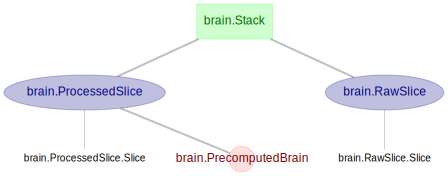

In [10]:
from atlas_pipeline import reference, brain
dj.ERD(brain.Stack) + 5

### In this framework, the synchronization is controlled by DataJoint via **insert()**, **populate()** and **fetch()**
This requires complete mirroring of the directory structure between S3 and the local file system of each lab. 

#### A small illustrative case:

Suppose *Lab A* has raw and processed slices for stack named *Stack_1*, ready to be ingested into DataJoint and sync with S3. This can be done via:

1. Create a record of a new stack named 'Stack_1'
```python
Stack.insert1(stack_name='Stack_1')
```
2. Insert raw slices of 'Stack_1' (found in **'./Lab_A/raw/Stack_1/'** to pipeline as well as uploading to S3 bucket 'mousebrainatlas-rawdata' with path **'raw/Stack_1/'**
```python
RawSlice.populate()
```
3. Insert raw slices of 'Stack_1' (found in **'./Lab_A/processed/Stack_1/'** to pipeline as well as uploading to S3 bucket 'mousebrainatlas-data' with path **'processed/Stack_1/'**

```python
ProcessedSlice.populate()
```


#### Any other collaborating lab, say *Lab B* can get access to *Stack_1* by synchronizing with S3 via **fetch()**

Note that *Lab B* needs to setup the *stores* config accordingly:
```python
dj.config['stores'] = {
        
    '@S3_raw': {    #  a single s3 for all collaborating labs in the study
        'protocol' : 's3',
        'endpoint' : 's3.amazonaws.com',
        'bucket' : 'mousebrainatlas-rawdata',
        'stage' : os.path.abspath('./Lab_B')  # lab B now
        **s3_creds
    },

    '@S3_processed': {    #  a single s3 for all collaborating labs in the study
        'protocol' : 's3',
        'endpoint' : 's3.amazonaws.com',
        'bucket' : 'mousebrainatlas-data',
        'stage' : os.path.abspath('./Lab_B')  # lab B
        **s3_creds
    },
}
```
Sync with S3:
```python
raws = (RawSlice.Slice & {'stack_name': 'Stack_1'}).fetch()
processeds = (ProcessedSlice.Slice & {'stack_name': 'Stack_1'}).fetch()
```